In [29]:
import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio


import matplotlib.pyplot as plt

In [30]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [31]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [32]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [33]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

print("Generator summary:", generator.summary())
print("Discriminator summary:", discriminator.summary())

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 6762)           │       939,918 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 6762)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 138)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 128)    │       282,752 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 1)      │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,491,215 (5.69 MB)

 Trainable params: 1,491,215 (5.69 MB)

 Non-trainable params: 0 (0.00 B)

Generator summary: None


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,385 (314.00 KB)

 Trainable params: 80,385 (314.00 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator summary: None


In [34]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }



In [35]:
# class outs1(keras.callbacks.Callback):

#     def on_batch_end(self, batch, logs={}):          
               
#         from keras import backend as K
#         from IPython.display import clear_output

#         if batch % 20 == 0:
#             clear_output(wait=True)

#             fig, axes = plt.subplots(12,4)

#             inp = self.model.discriminator.inputs
#             outputs = [layer.output for layer in self.model.discriminator.layers]

#             functors = [K.function([inp], [out]) for out in outputs]           
            
#             for i in range(12):
#                 layer_outs_1 = [func([x_test[i][np.newaxis,...]]) for func in functors]

#                 axes[i,0].imshow(x_test[i], cmap='viridis')
#                 axes[i,1].imshow(layer_outs_1[1][0][0,:,:,0], cmap='viridis')
#                 axes[i,2].imshow(layer_outs_1[3][0][0,:,:,0], cmap='viridis')
#                 axes[i,3].imshow(layer_outs_1[-1][0][:,:], cmap='viridis')

            
#             for i in range(12):
#                 for j in range(5):
#                     axes[i,j].axis('off')
#                     axes[i,j].set_xticks([])
#                     axes[i,j].set_yticks([])

#             fig.set_figheight(15)
#             fig.set_figwidth(8)

           
#             plt.show()


            



In [36]:
class outs1(keras.callbacks.Callback):

    def on_batch_end(self, batch, logs={}):          

        y_train_reshaped = keras.utils.to_categorical(y_train[0], 10)
        print(y_train_reshaped.shape)

        y_reshaped_2 = y_train_reshaped[None, :, None, None]
        y_reshaped_2 = ops.repeat(
            y_reshaped_2, repeats=[image_size * image_size]
        )
        y_reshaped_2 = ops.reshape(
            y_reshaped_2, (-1, image_size, image_size, num_classes)
        )
        
        x_train_2 = x_train[0][None, :, :, None]

        if batch % 20 == 1:
            new_array = np.concatenate([x_train_2, y_reshaped_2], axis=3)                    
            pred_outputs = self.model.discriminator.predict(new_array), discriminator_in_channels

            print(pred_outputs)

            test_1 = self.model.discriminator.layers[0](new_array)
            plt.imsave('/Users/user/Library/CloudStorage/OneDrive-Personal/Mac/PhD/Spect2/img_{0}_0.png'.format(batch), test_1[0, :, :, 0], cmap='viridis')
            print(test_1.shape)
            test_2 = self.model.discriminator.layers[1](test_1)
            plt.imsave('/Users/user/Library/CloudStorage/OneDrive-Personal/Mac/PhD/Spect2/img_{0}_1.png'.format(batch), test_2[0, :, :, 0], cmap='viridis')
            print(test_2.shape)
            test_3 = self.model.discriminator.layers[2](test_2)
            plt.imsave('/Users/user/Library/CloudStorage/OneDrive-Personal/Mac/PhD/Spect2/img_{0}_2.png'.format(batch), test_3[0, :, :, 0], cmap='viridis')
            print(test_3.shape)
            test_4 = self.model.discriminator.layers[3](test_3)
            plt.imsave('/Users/user/Library/CloudStorage/OneDrive-Personal/Mac/PhD/Spect2/img_{0}_3.png'.format(batch), test_4[0, :, :, 0], cmap='viridis')
            print(test_4.shape)
            test_5 = self.model.discriminator.layers[4](test_4)
            print(test_5.shape)
            test_6 = self.model.discriminator.layers[5](test_5)
            # plt.imsave('/Users/user/Library/CloudStorage/OneDrive-Personal/Mac/PhD/Spect2/img_{0}_3.png'.format(batch), test_6[0, :], cmap='viridis')
            print(test_6.shape)

            # from keras.models import Model

            # layer_name = 'conv2d_transpose_2'
            # intermediate_layer_model = Model(inputs=self.model.input,
            #                      outputs=self.model.generator.get_layer(layer_name).output)
            # intermediate_output = intermediate_layer_model.predict(x_train[0][None, :, :, None])

            # # show image of intermediate output
            # plt.imshow(intermediate_output[0, :, :, 0], cmap='viridis')

            # plt.imsave('/Users/user/Library/CloudStorage/OneDrive-Personal/Mac/PhD/Spect2/img.png', pred_outputs[-1], cmap='viridis')
            

In [37]:
class outs2(keras.callbacks.Callback):

    def on_batch_end(self, batch, logs={}):          

        if batch % 20 == 0:
            loss_d = logs.get('d_loss')
            loss_g = logs.get('g_loss')

            print('\nLoss discriminator: {0}, Loss generator: {1}'.format(loss_d, loss_g))

In [38]:
callbacks_list = [outs2()]

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), #(learning_rate=0.0003)
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20, callbacks=callbacks_list)


Epoch 1/20

Loss discriminator: 0.6914664506912231, Loss generator: 0.6105341911315918
  20/1094 ━━━━━━━━━━━━━━━━━━━━ 3:14 181ms/step - d_loss: 0.6682 - g_loss: 0.6934
Loss discriminator: 0.6605565547943115, Loss generator: 0.7167260646820068
  40/1094 ━━━━━━━━━━━━━━━━━━━━ 3:08 179ms/step - d_loss: 0.6666 - g_loss: 0.7054
Loss discriminator: 0.6637739539146423, Loss generator: 0.7239927649497986
  60/1094 ━━━━━━━━━━━━━━━━━━━━ 3:04 179ms/step - d_loss: 0.6633 - g_loss: 0.7142
Loss discriminator: 0.6464548707008362, Loss generator: 0.744534432888031
  80/1094 ━━━━━━━━━━━━━━━━━━━━ 3:00 178ms/step - d_loss: 0.6560 - g_loss: 0.7254
Loss discriminator: 0.6194649338722229, Loss generator: 0.777538537979126
 100/1094 ━━━━━━━━━━━━━━━━━━━━ 2:56 178ms/step - d_loss: 0.6456 - g_loss: 0.7400
Loss discriminator: 0.5872973799705505, Loss generator: 0.820364773273468
 120/1094 ━━━━━━━━━━━━━━━━━━━━ 2:53 178ms/step - d_loss: 0.6364 - g_loss: 0.7517
Loss discriminator: 0.6065781712532043, Loss generator:

KeyboardInterrupt: 

In [10]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 0  # @param {type:"slider", min:0, max:9, step:1}
end_class = 9  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



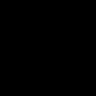

In [11]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")